# scmap for label transfer between our scRNAseq ref and Li et al 2017


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import sys
import warnings
import anndata
warnings.filterwarnings('ignore')


def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures_compare/scmap/'
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.4 scipy==1.5.3 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


'/opt/conda/bin/python'

## Load data
### Li et al. 2017 ref

In [2]:
Li2017_dir = '/nfs/team292/lg18/with_valentina/Li2017_hsaGonads_GSE86146/'

#Load meta
meta = pd.read_csv(Li2017_dir+'clusters_tableS1_sheet3.csv', header=0, index_col=0)
print(len(meta))

1845


In [3]:
# Note we need to traspose
Li2017_adataR = sc.read_csv(Li2017_dir+'FGC_tpm_expr.txt', delimiter='\t').T
Li2017_adataR = Li2017_adataR[[ i in meta.index for i in Li2017_adataR.obs_names ]]

Li2017_adataR.var_names_make_unique()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
#Add meta
Li2017_adataR.obs = pd.concat([Li2017_adataR.obs, meta[ [i in Li2017_adataR.obs.index for i in meta.index] ]], join='inner', axis=1)
print(Li2017_adataR.obs[0:5])
set(Li2017_adataR.obs['FullAnnot'])

                         Cluster    Annot             FullAnnot
F_10W_embryo1_sc10  Female_FGC#1  Mitotic  Female_FGC#1 Mitotic
F_10W_embryo1_sc11  Female_FGC#1  Mitotic  Female_FGC#1 Mitotic
F_10W_embryo1_sc12  Female_FGC#1  Mitotic  Female_FGC#1 Mitotic
F_10W_embryo1_sc13  Female_FGC#1  Mitotic  Female_FGC#1 Mitotic
F_10W_embryo1_sc15  Female_FGC#1  Mitotic  Female_FGC#1 Mitotic


{'Female_FGC#1 Mitotic',
 'Female_FGC#2 RA responsive',
 'Female_FGC#3 Meiotic',
 'Female_FGC#4 Oogenesis',
 'Female_Soma#1 Endothelial',
 'Female_Soma#2 early Granulosa',
 'Female_Soma#3 mural granulosa',
 'Female_Soma#4 late granulosa',
 'Male_FGC#1 Migrating',
 'Male_FGC#2 Mitotic',
 'Male_FGC#3 Mitotic arrest',
 'Male_Soma#1 Endothelial',
 'Male_Soma#2 Sertoli',
 'Male_Soma#3 precursor Leydig',
 'Male_Soma#4 differetniated Leydig'}

In [5]:
Li2017_adataR.obs['clusters'] = Li2017_adataR.obs['FullAnnot']
Li2017_adataR.obs['clusters'].value_counts(dropna = False)
Li2017_adataR = Li2017_adataR[[ 'Female' in i for i in Li2017_adataR.obs['clusters']]]

### our atlas

In [6]:
gonadsAtlasR = sc.read('/nfs/team292/lg18/with_valentina/gonadsV2_revision/FCA-gonads_rawcounts.h5ad')

In [7]:
# Add old cluster subname
metaF = pd.read_csv('/nfs/team292/lg18/with_valentina/gonadsV2_revision/FCA-gonads_female_annotated.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF.head()

metaM = pd.read_csv('/nfs/team292/lg18/with_valentina/gonadsV2_revision/FCA-gonads_male_annotated.csv')
metaM = metaM.set_index('Unnamed: 0')
metaM.head()


cell_annotM = metaM['lineage'].to_dict()
cell_annotF = metaF['lineage'].to_dict()
cell_annot = {**cell_annotM , **cell_annotF}
gonadsAtlasR.obs['lineage'] = gonadsAtlasR.obs_names.map(cell_annot).astype('category')

In [8]:
gonadsAtlasR = gonadsAtlasR[[ not pd.isna(i) for i in gonadsAtlasR.obs.lineage ]]
gonadsAtlasR = gonadsAtlasR[[i not in ['lowQC', 'Doublet', 'cont'] for i in gonadsAtlasR.obs.lineage]]
gonadsAtlasR = gonadsAtlasR[['female' in i for i in gonadsAtlasR.obs.sex]]
# gonadsAtlasR

In [9]:
gonadsAtlas = anndata.AnnData(X=gonadsAtlasR.X, var=gonadsAtlasR.var, obs=gonadsAtlasR.obs, asview=False)

## Intersect genes

In [10]:
sc_genes = Li2017_adataR.var_names.to_list()
sn_genes = gonadsAtlas.var_names.to_list()

common_genes = list(set(Li2017_adataR.var.index.values).intersection(gonadsAtlas.var.index.values))
print('common genes: ', len(common_genes))
gonadsAtlas = gonadsAtlas[:,common_genes]
Li2017_adataR = Li2017_adataR[:,common_genes]
print(gonadsAtlas.X.shape)
print(Li2017_adataR.X.shape)

common genes:  19343
(218951, 19343)
(992, 19343)


## R2PY setup


In [11]:
import rpy2.rinterface_lib.callbacks
import logging

In [12]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [13]:
import anndata2ri
anndata2ri.activate()

In [14]:
%load_ext rpy2.ipython

## scmap

In [15]:
%%R
library(Matrix)
library(scmap)

In [16]:
%%R -i Li2017_adataR
Li2017_adataR

class: SingleCellExperiment 
dim: 19343 992 
metadata(0):
assays(1): X
rownames(19343): UXT-AS1 ZNF879 ... SULT2A1 CTAGE1
rowData names(0):
colnames(992): F_10W_embryo1_sc10 F_10W_embryo1_sc11 ...
  F_8W_embryo1_sc93 F_8W_embryo1_sc94
colData names(4): Cluster Annot FullAnnot clusters
reducedDimNames(0):
altExpNames(0):


In [17]:
adataDown = sc.pp.subsample(gonadsAtlas, fraction=0.5, random_state=0, copy=True)
adataDown = anndata.AnnData(X=adataDown.X, var=adataDown.var, obs=adataDown.obs, asview=False)
sc.pp.filter_genes(adataDown, min_cells=10)

filtered out 888 genes that are detected in less than 10 cells


In [18]:
adataDown.X = adataDown.X.toarray()

In [19]:
%%R -i adataDown
rowData(adataDown)$feature_symbol <- rownames(adataDown)
adataDown

class: SingleCellExperiment 
dim: 18455 109475 
metadata(0):
assays(1): X
rownames(18455): UXT-AS1 ZNF879 ... SULT2A1 CTAGE1
rowData names(223): gene_ids.0 feature_types.0 ... variances_norm
  feature_symbol
colnames(109475): FCA_GND8047885_GTTACAGAGAGATGAG
  HD_F_GON9480064_TGTCCCATCCAACCAA ... HD_F_GON9525515_CCATGTCGTGCGAAAC
  HD_F_GON9480064_ACCAGTAGTGGCGAAT
colData names(36): n_genes sample ... trimester lineage
reducedDimNames(0):
altExpNames(0):


In [20]:
%%R 

counts <- assay(Li2017_adataR, "X")
libsizes <- colSums(counts)
size.factors <- libsizes/mean(libsizes)
logcounts(Li2017_adataR) <- log2(t(t(counts)/size.factors) + 1)
assayNames(Li2017_adataR)

[1] "X"         "logcounts"



FALSE  TRUE 
18943   400 


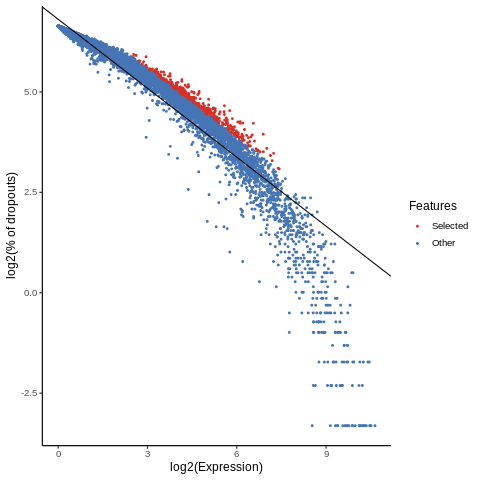

In [21]:
%%R

rowData(Li2017_adataR)$feature_symbol <- rownames(Li2017_adataR)
logcounts(Li2017_adataR) <- as.matrix(logcounts(Li2017_adataR))
Li2017_adataR <- selectFeatures(Li2017_adataR, n_features = 400, suppress_plot = FALSE)
print(table(rowData(Li2017_adataR)$scmap_features))

       Female_FGC#1 Mitotic Female_Soma#2 early Granulosa
ACOT13             6.527081                             0
ACTG2              8.490646                             0
ACTN1              7.246466                             0
AEN                6.858303                             0
AGA                5.660768                             0
AGGF1              5.445900                             0
       Female_Soma#4 late granulosa Female_FGC#2 RA responsive
ACOT13                            0                   7.496550
ACTG2                             0                   1.478681
ACTN1                             0                   0.000000
AEN                               0                   2.234505
AGA                               0                   6.781724
AGGF1                             0                   6.960543
       Female_Soma#3 mural granulosa Female_FGC#3 Meiotic
ACOT13                      2.968622             6.326011
ACTG2                       0.000000 

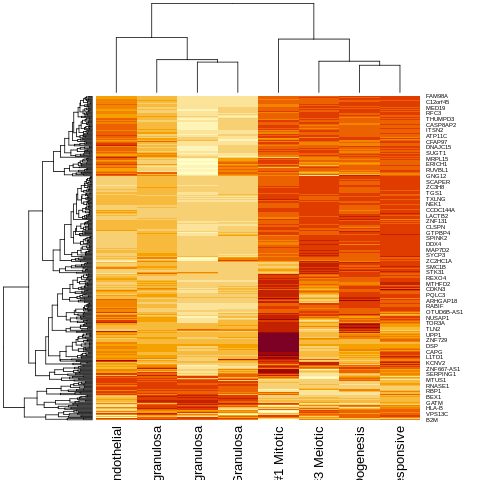

In [22]:
%%R 

Li2017_adataR <- indexCluster(Li2017_adataR, cluster_col = "clusters")
print(head(metadata(Li2017_adataR)$scmap_cluster_index))
heatmap(as.matrix(metadata(Li2017_adataR)$scmap_cluster_index))

In [23]:
%%R 

counts <- assay(adataDown, "X")
libsizes <- colSums(counts)
size.factors <- libsizes/mean(libsizes)
logcounts(adataDown) <- log2(t(t(counts)/size.factors) + 1)
logcounts(adataDown) <- as.matrix(logcounts(adataDown))
assayNames(adataDown)

[1] "X"         "logcounts"


In [24]:
%%R -o scmapCluster_results

scmapCluster_results <- scmapCluster(
  projection = adataDown,  threshold = 0.5,
  index_list = list(
    Li2017_adataR = metadata(Li2017_adataR)$scmap_cluster_index
  )
)

In [25]:
%%R 

print(head(scmapCluster_results$scmap_cluster_labs))
print(head(scmapCluster_results$scmap_cluster_siml))
print(head(scmapCluster_results$combined_labs))

     Li2017_adataR                  
[1,] "Female_Soma#2 early Granulosa"
[2,] "unassigned"                   
[3,] "Female_Soma#2 early Granulosa"
[4,] "unassigned"                   
[5,] "Female_Soma#4 late granulosa" 
[6,] "Female_Soma#4 late granulosa" 
     Li2017_adataR
[1,]     0.6252885
[2,]            NA
[3,]     0.5964094
[4,]     0.3389273
[5,]     0.7315452
[6,]     0.6435922
[1] "Female_Soma#2 early Granulosa" "unassigned"                   
[3] "Female_Soma#2 early Granulosa" "unassigned"                   
[5] "Female_Soma#4 late granulosa"  "Female_Soma#4 late granulosa" 


In [26]:
scmapCluster_results

scmap_cluster_labs,[RTYPES.STRSXP]
scmap_cluster_siml,[RTYPES.REALSXP]
combined_labs,[RTYPES.STRSXP]


In [27]:
labels = list(scmapCluster_results[0])
adataDown.obs['scmap_labels'] = labels
adataDown.obs['scmap_labels'].value_counts(dropna = False)

unassigned                       32720
Female_Soma#2 early Granulosa    22601
Female_Soma#3 mural granulosa    21553
Female_Soma#4 late granulosa     21020
Female_Soma#1 Endothelial         7821
Female_FGC#2 RA responsive        1569
Female_FGC#1 Mitotic              1181
Female_FGC#3 Meiotic               747
Female_FGC#4 Oogenesis             263
Name: scmap_labels, dtype: int64

In [28]:
similarities = scmapCluster_results[1]
similarities = [val for sublist in similarities for val in sublist]
#similarities
adataDown.obs['scmap_similarities'] = similarities

In [29]:
adataDown.obs[['scmap_labels', 'scmap_similarities']].to_csv('/nfs/team292/lg18/with_valentina/Li2017pred_females.csv')

In [30]:
# sc.pl.umap(gonadsAtlasR, color='scmap_labels')
# sc.pl.umap(gonadsAtlasR, color='scmap_similarities')
# sc.pl.umap(gonadsAtlasR, color='clusters')